# Exploring San Francisco Police Department Incident Reports

> SF OpenData is the City and County of San Francisco's official open data portal and is a product of the official open data program, DataSF. Their mission is to empower the use of data.
>
> One of their published dataset is San Francisco Police Department's Incident Reports (Historical). This dataset has over 2 million records and a good number of fields which makes it a good dataset for learning Apache Spark while analysing the data.
>
> For more details about the dataset, please visit [their official website](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-Historical-2003/tmnf-yvry).

Let's get started!

### Step 1: Downloading the data

First we send a HTTP GET request and fetch the data.

In [1]:
import requests

download_file = requests.get('https://data.sfgov.org/api/views/tmnf-yvry/rows.csv?accessType=DOWNLOAD')
if download_file.status_code != 200:
    print('Error while fetching the data')
else:
    print('Data successfully received')

Data successfully received


Let's look at the location where this data will be saved.

In [2]:
import os
import sys

filename = os.path.join(os.path.dirname(sys.argv[0]), download_file.headers['content-disposition'].split(';')[-1].strip().split('=')[-1])
print('Data will be saved in: ' + filename)

Data will be saved in: c:\users\sudip.a.banerjee\pycharmprojects\learning\venv\lib\site-packages\Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv


Now we save the data in a file.

In [3]:
op_file = open(filename, 'wb')
op_file.write(download_file.content)
op_file.close()

### Step 2: Reading the file in Spark

Let's initiate a SparkSession.

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('SF_Police_Dept_Incident_Statistics').getOrCreate()

Loading the CSV file.

In [5]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType, LongType

schema = StructType([
                StructField('IncidntNum', IntegerType(), True)
                , StructField('Category', StringType(), True)
                , StructField('Descript', StringType(), True)
                , StructField('DayOfWeek', StringType(), True)
                , StructField('Date', StringType(), True)
                , StructField('Time', StringType(), True)
                , StructField('PdDistrict', StringType(), True)
                , StructField('Resolution', StringType(), True)
                , StructField('Address', StringType(), True)
                , StructField('X', DoubleType(), True)
                , StructField('Y', DoubleType(), True)
                , StructField('Location', StringType(), True)
                , StructField('PdId', LongType(), True)
            ])
input_data = spark.read.csv(filename, header=True, sep=',', schema=schema)

Let's see the top 5 rows of the DataFrame.

We're using 'toPandas()' so that the output is rendered well in Jupyter.
> NOTE: This isn't necessary in case of a production environment.

In [6]:
input_data.limit(5).toPandas()

IncidntNum        Category                 Descript  DayOfWeek        Date  \
0   146196161    NON-CRIMINAL            LOST PROPERTY    Tuesday  09/23/2014   
1   150045675         ASSAULT                  BATTERY   Thursday  01/15/2015   
2   140632022  SUSPICIOUS OCC  INVESTIGATIVE DETENTION  Wednesday  07/30/2014   
3   150383259         ASSAULT                  BATTERY   Saturday  05/02/2015   
4    40753980  OTHER OFFENSES         RECKLESS DRIVING     Friday  07/02/2004   

    Time PdDistrict      Resolution                   Address           X  \
0  01:00   SOUTHERN            NONE    800 Block of BRYANT ST -122.403405   
1  17:00    TARAVAL            NONE  1800 Block of VICENTE ST -122.485604   
2  09:32    BAYVIEW            NONE  100 Block of GILLETTE AV -122.396535   
3  23:10    BAYVIEW  ARREST, BOOKED   2400 Block of PHELPS ST -122.400131   
4  13:43    BAYVIEW            NONE   I-280 / CESAR CHAVEZ ST -120.500000   

           Y                                    Location            PdId  
0  37.775421   POINT (-122.403404791479 37.775420706711)  14619616171000  
1  37.738821   POINT (-122.48560378101 37.7388214326705)  15004567504134  
2  37.710660  POINT (-122.396535107224 37.7106603302503)  14063202264085  
3  37.730093  POINT (-122.400130573297 37.7300925390327)  15038325904134  
4  90.000000                           POINT (-120.5 90)   4075398065020

Also, let's see the number of records in the file.

In [7]:
print('The file has', input_data.count(), 'records.')

The file has 2215024 records.


### Step 3: Preparing the data for analysis

While exploring the dataset, it's observed that the dataset only has records till May 2018. This means that annual KPIs for the year 2018 won't reflect the correct numbers.

In [8]:
from pyspark.sql.functions import to_date, min, max

input_data.select(to_date('Date', format='MM/dd/yyyy').alias('Date')).agg(min('Date').alias('Start_Date'), max('Date').alias('End_Date')).toPandas()

Start_Date    End_Date
0  2003-01-01  2018-05-15

While exploring the dataset, it was also observed that the field 'IncidntNum' is not the key field. Some of the Incidents have multiple records with different Year, Category and Addresses; all having the same 'IncidntNum'.

In [9]:
from pyspark.sql.functions import year, countDistinct, greatest

inc_with_multiples = input_data.select('IncidntNum', year(to_date('Date', format='MM/dd/yyyy')).alias('Year'), 'Category', 'Address')\
                            .orderBy('IncidntNum')\
                            .groupBy('IncidntNum')\
                            .agg(countDistinct('Year').alias('Distinct_Years'), countDistinct('Category').alias('Distinct_Categories'), countDistinct('Address').alias('Distinct_Addresses'))\
                            .filter('Distinct_Years > 1 AND Distinct_Categories > 1 AND Distinct_Addresses > 1')\
                            .select('IncidntNum', greatest('Distinct_Years', 'Distinct_Categories', 'Distinct_Addresses').alias('Greatest'))\
                            .orderBy('IncidntNum')

input_data.select('IncidntNum', year(to_date('Date', format='MM/dd/yyyy')).alias('Year'), 'Category', 'Address')\
        .orderBy('IncidntNum')\
        .join(inc_with_multiples, 'IncidntNum')\
        .orderBy(['Greatest', 'IncidntNum', 'Year', 'Category', 'Address'], ascending=[0, 1, 1, 1, 1])\
        .select('IncidntNum', 'Year', 'Category', 'Address')\
        .limit(10).toPandas()

IncidntNum  Year         Category                     Address
0    90068024  2009          ASSAULT  1500 Block of SUNNYDALE AV
1    90068024  2009   OTHER OFFENSES  1500 Block of SUNNYDALE AV
2    90068024  2009   OTHER OFFENSES  1500 Block of SUNNYDALE AV
3    90068024  2009  SECONDARY CODES  1500 Block of SUNNYDALE AV
4    90068024  2009      WEAPON LAWS  1500 Block of SUNNYDALE AV
5    90068024  2009      WEAPON LAWS  1500 Block of SUNNYDALE AV
6    90068024  2010          ASSAULT      800 Block of BRYANT ST
7    90068024  2010          ASSAULT      800 Block of BRYANT ST
8    90068024  2010      WEAPON LAWS      800 Block of BRYANT ST
9    90327438  2009    DRUG/NARCOTIC       400 Block of MINNA ST

Performance Optimisation:

While exploring the dataset, it was noticed that some of the steps will be repeated everytime we perform any analysis. Thus, it's a good practice to prepare and cache the intermediate DataFrame having only the required fields.

Why should one use caching?
* Reading from memory is faster than reading from any other source. We shouldn't hit the source multiple times but only once.
* Huge performance benefits can be achieved as we save time and resources which would have been otherwise spent in recomputing the repetitive transformations and aggregations.

Now, the operations which we'll cache include:
* Creating DateTime: We'll concatenate the fields 'Date' and 'Time' and then cast it to a TIMESTAMP field.
* Filter the incomplete year: Since we don't have the complete data for the year 2018, we will filter out all the records for that year so that any analysis on annual KPIs are accurate.
* Unique record for each IncidntNum: We'll rank the records of each Incident in the order of DateTime. Then, we'll filter to consider only the earliest record and discard others.

In [10]:
from pyspark.sql import Window
from pyspark.sql.functions import concat_ws, to_timestamp, row_number

df = input_data.select('IncidntNum', to_timestamp(concat_ws(' ', 'Date', 'Time'), format='MM/dd/yyyy HH:mm').alias('DateTime'), 'Category', 'PdDistrict', 'X', 'Y')\
            .filter(year('DateTime') != 2018)\
            .orderBy(['IncidntNum', 'DateTime'])\
            .withColumn('Rank', row_number().over(Window.partitionBy('IncidntNum').orderBy('DateTime')))\
            .filter('Rank == 1')\
            .select('IncidntNum', 'DateTime', 'Category', 'PdDistrict', 'X', 'Y')

df.cache().limit(5).toPandas()

IncidntNum            DateTime      Category  PdDistrict           X  \
0      259633 2005-09-26 13:11:00      WARRANTS   INGLESIDE -122.438294   
1      879366 2004-07-29 11:30:00      WARRANTS    NORTHERN -122.421874   
2    21371258 2004-07-03 08:40:00      WARRANTS    SOUTHERN -122.406691   
3    30002907 2003-01-01 17:48:00  NON-CRIMINAL  TENDERLOIN -122.412597   
4    30005309 2003-01-02 05:00:00     VANDALISM     TARAVAL -122.504331   

           Y  
0  37.717137  
1  37.780132  
2  37.785207  
3  37.781119  
4  37.753010

### Step 4: Analysing the data

1. How did the Incident Count change over Time?

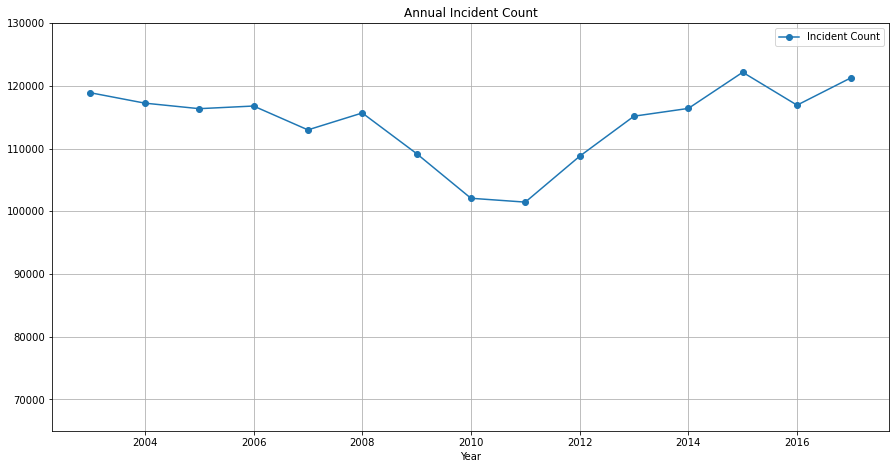

In [11]:
%matplotlib inline

from pyspark.sql.functions import count

df.select(year('DateTime').alias('Year')).orderBy('Year').groupBy('Year').agg(count('Year').alias('Incident Count'))\
        .toPandas().set_index('Year').plot(kind='line', figsize=(15, 7.5), title='Annual Incident Count', marker='o', grid=True, ylim=(65000, 130000))

2. What time of the day observes a peak / dip in the Incident Count?

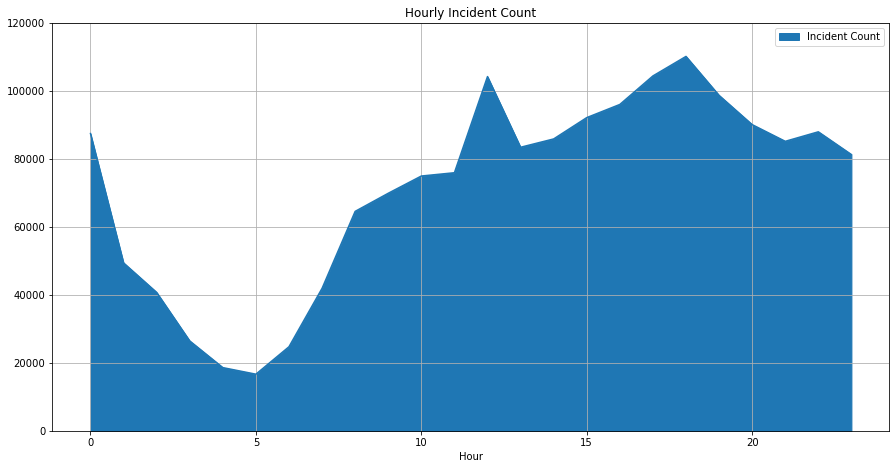

In [12]:
%matplotlib inline

from pyspark.sql.functions import hour

df.select(hour('DateTime').alias('Hour')).orderBy('Hour').groupBy('Hour').agg(count('Hour').alias('Incident Count'))\
        .toPandas().set_index('Hour').plot(kind='area', figsize=(15, 7.5), title='Hourly Incident Count', grid=True, ylim=(0, 120000))

3. Which category of incidents are recorded the most?

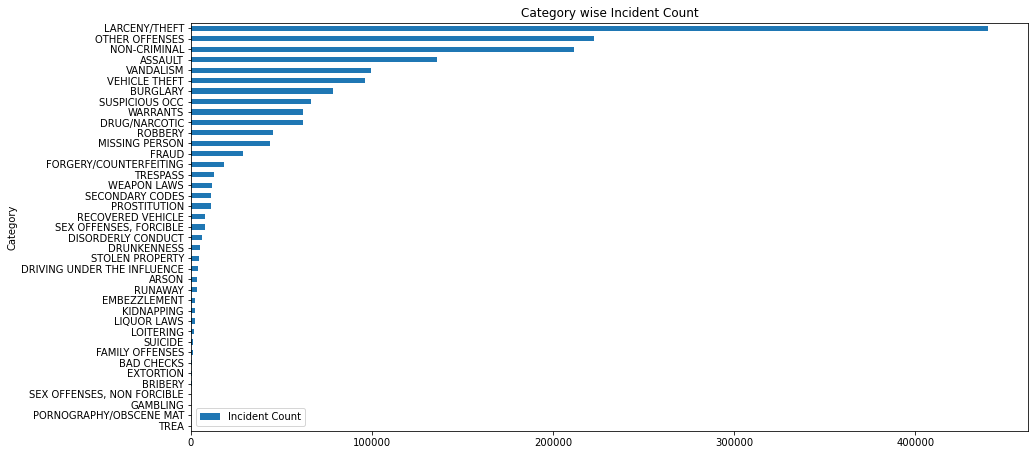

In [13]:
%matplotlib inline

df.select('Category').orderBy('Category').groupBy('Category').agg(count('Category').alias('Incident Count')).orderBy('Incident Count')\
        .toPandas().set_index('Category').plot(kind='barh', figsize=(15, 7.5), title='Category wise Incident Count')

4. Which district records the highest Incident Count?

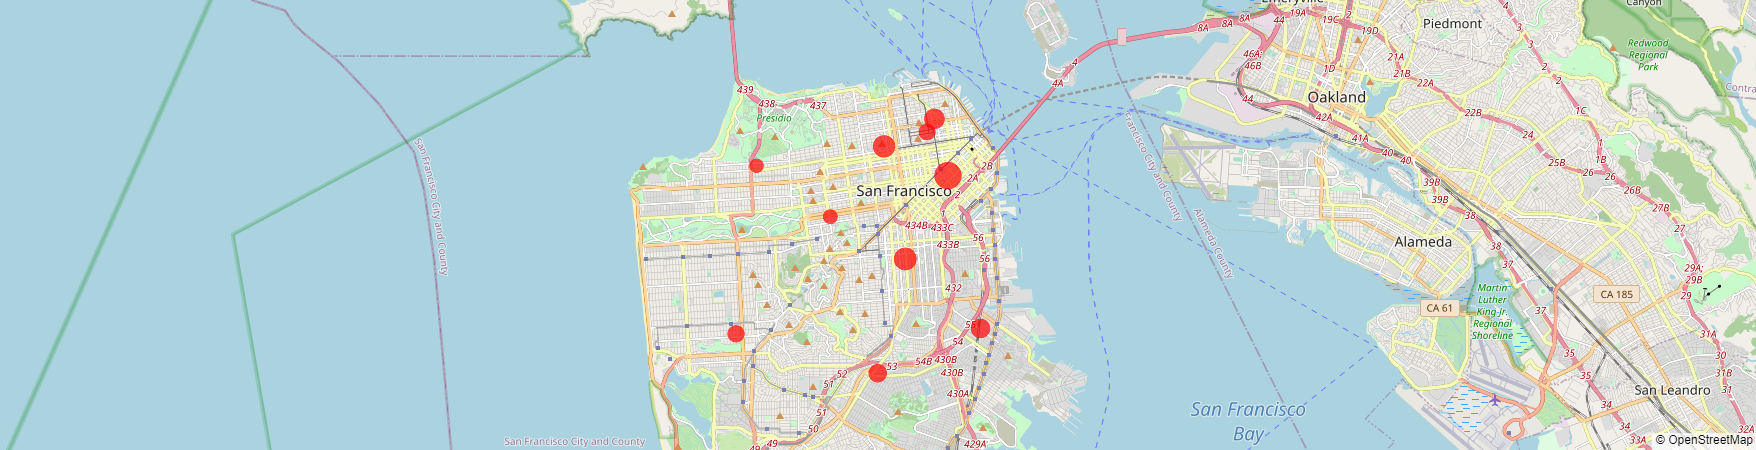

In [14]:
import plotly.express as px
from pyspark.sql.functions import avg

pd_df = df.select('PdDistrict', 'X', 'Y')\
        .filter('PdDistrict <> \'null\'')\
        .orderBy('PdDistrict')\
        .groupBy('PdDistrict')\
        .agg(avg('X').alias('X_Avg'), avg('Y').alias('Y_Avg'), count('PdDistrict').alias('Incident_Count'))\
        .toPandas()

fig = px.scatter_mapbox(pd_df, lat='Y_Avg', lon='X_Avg', size='Incident_Count', hover_name='PdDistrict', zoom=11, color_discrete_sequence=["red"])
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In some systems (ex. GitHub), the above map visualization may not render. Thus, adding the screenshot.

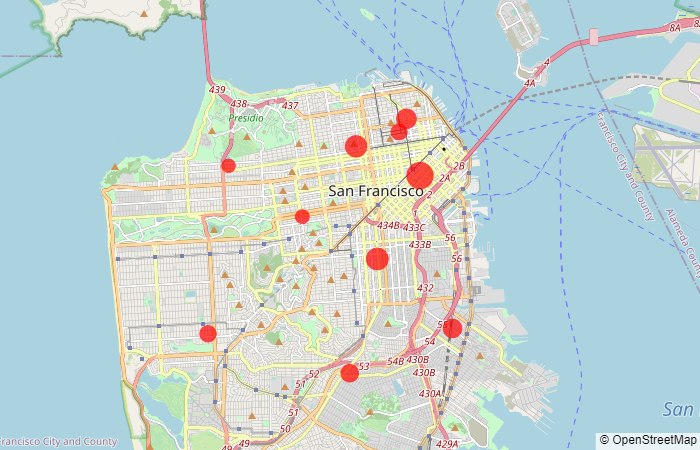

In [15]:
from IPython.display import Image
Image(filename='C:\\Users\\sudip.a.banerjee\\Desktop\\newplot.png')

5. Which Incident Category has observed growth over time (only considering the top 95% categories)?

> To perform this analysis, we create a Temporary View out of our DataFrame and query it using SQL.

In [16]:
df.createOrReplaceTempView('DATA')

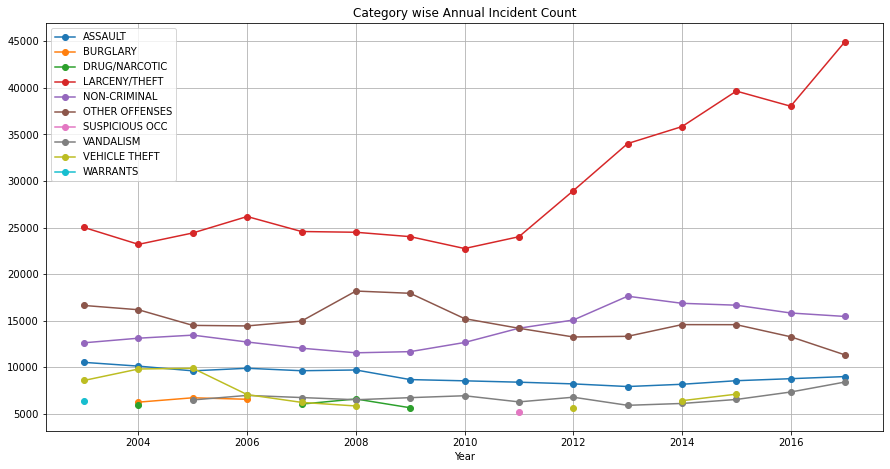

In [17]:
%matplotlib inline

spark.sql("""
SELECT
    Year
    , Category
    , Incident_Count
FROM
    (
        SELECT
            *
            , (Incident_Count / (sum(Incident_Count) over(PARTITION BY Year))) AS Per_Share
        FROM
            (
                SELECT
                    year(DateTime) AS Year
                    , Category
                    , count(1) AS Incident_Count
                FROM
                    DATA
                GROUP BY
                    Year
                    , Category
            )
    )
WHERE
    Per_Share >= 0.05
ORDER BY
    Year
""").groupBy('Year').pivot('Category').sum('Incident_Count')\
.toPandas().set_index('Year').plot(kind='line', figsize=(15, 7.5), title='Category wise Annual Incident Count', marker='o', grid=True)